In [400]:
import numpy as np
import pandas as pd
import warnings
import random


from globalbonds.dataio.data_lib import DataLib
from globalbonds.indicators.data_utils import *
from globalbonds.indicators.signal import Signal
from globalbonds.indicators.indicator import Indicator
from globalbonds.indicators.assess_signal import predictive_accuracy
from globalbonds.indicators.return_utils import *
from globalbonds.indicators.normalization import *


from plotnine import *

from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

warnings.filterwarnings('ignore')


COUNTRIES = ['USA', 'JPN', 'AUS', 'DEU']
COUNTRIES = ['JPN', 'CAN', 'ESP', 'DEU', 'ITA', 'GBR', 'NOR', 'AUS', 'USA', 'SWE']
dlib = DataLib('../SignalData')
START_DATE = '1983-01-01'
END_DATE = '2010-01-01'
END_DATE = '2020-01-01'




def sharpe_ratio(bond_returns, cash_rate, signal, signal_weights=1):
    """Return the Sharpe ratio for a signal."""
    signal = signal.copy().fillna(0)
    bond_returns = bond_returns.pct_change()
    signal_returns = bond_returns * signal
    signal_returns = signal_returns.sum(axis=1) 
    signal_returns -= cash_rate
    signal_returns *= signal_weights
    sharpe = signal_returns.mean() / signal_returns.std()
    return sharpe


def calc_signal_risk_adj_returns(bond_returns, cash_rate, signal, signal_weights=1):
    """Return a Series of returns (as fraction of initial investment) for a signal."""
    signal = signal.copy().fillna(0)
    bond_returns = bond_returns.pct_change()
    signal_returns = bond_returns * signal
    signal_returns = signal_returns.sum(axis=1) 
    signal_returns -= cash_rate
    signal_returns *= signal_weights
    signal_returns += 1
    signal_returns = signal_returns.cumprod()
    return signal_returns


def calc_signal_risk_adj_vol_adj_returns(bond_returns, cash_rate, signal, signal_weights=1):
    """Return a Series of returns (as fraction of initial investment) for a signal."""
    signal = signal.copy().fillna(0)
    bond_returns = bond_returns.pct_change()
    signal_returns = bond_returns * signal
    signal_returns = signal_returns.sum(axis=1) 
    signal_returns -= cash_rate
    signal_returns *= signal_weights
    signal_returns /= signal_returns.std()
    signal_returns += 1
    signal_returns = signal_returns.cumprod()
    return signal_returns


def get_passive_vol_adj_return(bond_returns, cash_rate, country='USA'):
    risk_free_returns = bond_returns[country].pct_change() + 1
    risk_free_returns -= cash_rate
    risk_free_returns /= risk_free_returns.std()
    risk_free_returns += 1
    risk_free_returns = risk_free_returns.cumprod()
    return risk_free_returns


def get_passive_return(bond_returns, cash_rate, country='USA'):
    risk_free_returns = bond_returns[country].pct_change() + 1
    risk_free_returns /= (1 + cash_rate)
    risk_free_returns = risk_free_returns.cumprod()
    return risk_free_returns

def annualized_return(return_curve):
    t = return_curve.index[-1].to_timestamp() - return_curve.index[0].to_timestamp() 
    t = t.days / 365.25
    r = return_curve.iloc[-1] / return_curve.iloc[0]
    ar = r ** (1 / t)
    return ar


def mask(tbl):
    tbl = tbl[COUNTRIES]
    tbl = tbl.loc['1980-01-01':END_DATE]
    return tbl

def get_setup(dlib, mask, start_date, end_date):
    bond_returns = mask(dlib.pull('BondRetIdx-LocalFX')).resample('M').mean()
    cash_rate = get_cash_rate(dlib)
    optimal_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, get_optimal_signal(bond_returns))
    optimal_returns = optimal_returns.loc[start_date: end_date]
    passive_10yrs = get_passive_return(bond_returns, cash_rate)
    passive_10yrs = passive_10yrs.loc[start_date: end_date]
    bond_returns = bond_returns.loc[start_date: end_date]
    cash_rate = cash_rate.loc[start_date: end_date]
    return bond_returns, cash_rate, optimal_returns, passive_10yrs

bond_returns, cash_rate, optimal_returns, passive_10yrs = get_setup(dlib, mask, START_DATE, END_DATE)

dlib.list()

['GDP-Real',
 'EquityPrices',
 'LongRates',
 'CurrAcctNom-inUSD',
 'CoreCPI-SA',
 'fxTrdWts-Real',
 'M3-inUSD',
 'RiskFree-Rate',
 'CurrAcctPctGDP',
 'fxTrdWts-Nominal',
 'BondRetIdx-LocalFX',
 'fxVsUSD',
 'M2-inUSD',
 'M1-inUSD',
 'ShortRates',
 'GDP-Nominal']

In [330]:
# Momentum

def get_momentum(bond_returns, start_date, end_date):
    momentum_sig = get_momentum_signal(bond_returns, window=12)
    momentum_sig += get_momentum_signal(bond_returns, window=36)
    momentum_sig = momentum_sig.loc[start_date:end_date]
    momentum_sig = signalize(momentum_sig).fillna(0)
    momentum_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, momentum_sig)
    print('Net Momentum RAR', momentum_returns.iloc[-1])
    return momentum_sig, momentum_returns

momentum_sig, momentum_returns = get_momentum(bond_returns, START_DATE, END_DATE)

Net Momentum RAR 1.9266483464224644


In [278]:
# Growth

def get_gdp(dlib, mask, start_date, end_date):
    gdp = mask(dlib.pull('GDP-Real'))
    gdp = gdp.resample('M').pad()
    gdp = derivative(gdp, s=1).rolling(6).mean()
    gdp = center_scale_using_historical_rolling(gdp, window=24, gap=1)
    gdp *= -1
    gdp_sig = signalize(gdp).fillna(0)
    gdp_sig = gdp_sig.loc[start_date:end_date]
    gdp_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, gdp_sig)
    print('Net GDP CER', gdp_returns.iloc[-1])
    return gdp_sig, gdp_returns

def get_eqs(dlib, mask, start_date, end_date):
    eqs = mask(dlib.pull('EquityPrices'))
    eqs = eqs.resample('M').mean()
    W = 12
    eqs = eqs.rolling(W).apply(lambda x: (x[W - 1] - x[W - 2])/ x[:W - 1].max())
    eqs_sig = signalize(eqs).fillna(0)
    eqs_sig = eqs_sig.loc[start_date:end_date]
    eqs_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, eqs_sig)
    print('Net Equity CER', eqs_returns.iloc[-1])
    return eqs_sig, eqs_returns

def get_growth(dlib, mask, start_date, end_date):
    gdp_sig, gdp_returns = get_gdp(dlib, mask, start_date, end_date)
    eqs_sig, eqs_returns = get_eqs(dlib, mask, start_date, end_date)
    pick_gdp = gdp_sig.apply(extremity, axis=1) > eqs_sig.apply(extremity, axis=1)
    print('GDP Picks (%)', 100 * pick_gdp.sum() / pick_gdp.shape[0])
    growth_sig = eqs_sig.copy()
    growth_sig[pick_gdp] = gdp_sig[pick_gdp]

    growth_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, growth_sig)
    print('Net Growth CER', growth_returns.iloc[-1])
    return growth_sig, growth_returns

growth_sig, growth_returns = get_growth(dlib, mask, START_DATE, END_DATE)

Net GDP CER 0.29655167274603517
Net Equity CER 2.533471857950543
GDP Picks (%) 6.51685393258427
Net Growth CER 2.9269140150497788


In [338]:
# Inflation

def get_m2(dlib, mask, start_date, end_date):
    m2 = mask(dlib.pull('M2-inUSD'))
    m2_3m = m2.rolling(3).mean()
    m2_12m = m2.rolling(12).mean()
    m2 = m2_3m / m2_12m
    m2 = center_scale_using_historical_rolling(m2, window=6, gap=1)
    m2_sig = signalize(m2).fillna(0)
    m2_sig = m2_sig.loc[start_date:end_date]
    m2_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, m2_sig)
    print('Net M2 RAR', m2_returns.iloc[-1])
    return m2_sig, m2_returns

def get_cpi(dlib, mask, start_date, end_date):
    cpi = mask(dlib.pull('CoreCPI-SA'))
    cpi = derivative(cpi, s=3)
    cpi = -cpi
    cpi = center_scale_using_historical_rolling(cpi, window=6, gap=1)
    cpi_sig = signalize(cpi).fillna(0)
    cpi_sig = cpi_sig.loc[start_date:end_date]
    cpi_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, cpi_sig)
    print('Net CPI RAR', cpi_returns.iloc[-1])
    return cpi_sig, cpi_returns

def get_fx(dlib, mask, start_date, end_date):
    fx = mask(dlib.pull('fxVsUSD'))
    fx['USA'] = 1 / fx.drop(columns='USA').mean(axis=1)
    W = 2
    fx = fx.rolling(W).apply(lambda x: x[W - 1] / x[:W - 1].mean())
    fx = derivative(fx, s=6)
    fx = fx.applymap(lambda x: 1 / x)
    fx_sig = signalize(fx.resample('M').mean()).fillna(0)
    fx_sig = fx_sig.loc[start_date:end_date]
    fx_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, fx_sig)
    print('Net FX RAR', fx_returns.iloc[-1])
    return fx_sig, fx_returns

def get_inflation(dlib, mask, start_date, end_date):
    m2_sig, m2_returns = get_m2(dlib, mask, start_date, end_date)
    cpi_sig, cpi_returns = get_cpi(dlib, mask, start_date, end_date)
    fx_sig, fix_returns = get_fx(dlib, mask, start_date, end_date)
    inflation_sig = signalize(2 * fx_sig + 2 * cpi_sig + 2 * m2_sig)
    inflation_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, inflation_sig)
    print('Net Inflation RAR', inflation_returns.iloc[-1])
    return inflation_sig, inflation_returns

inflation_sig, inflation_returns = get_inflation(dlib, mask, START_DATE, END_DATE)

Net M2 RAR 0.3036495961245047
Net CPI RAR 0.4245303976748969
Net FX RAR 0.40547000751921825
Net Inflation RAR 0.5932295297937474


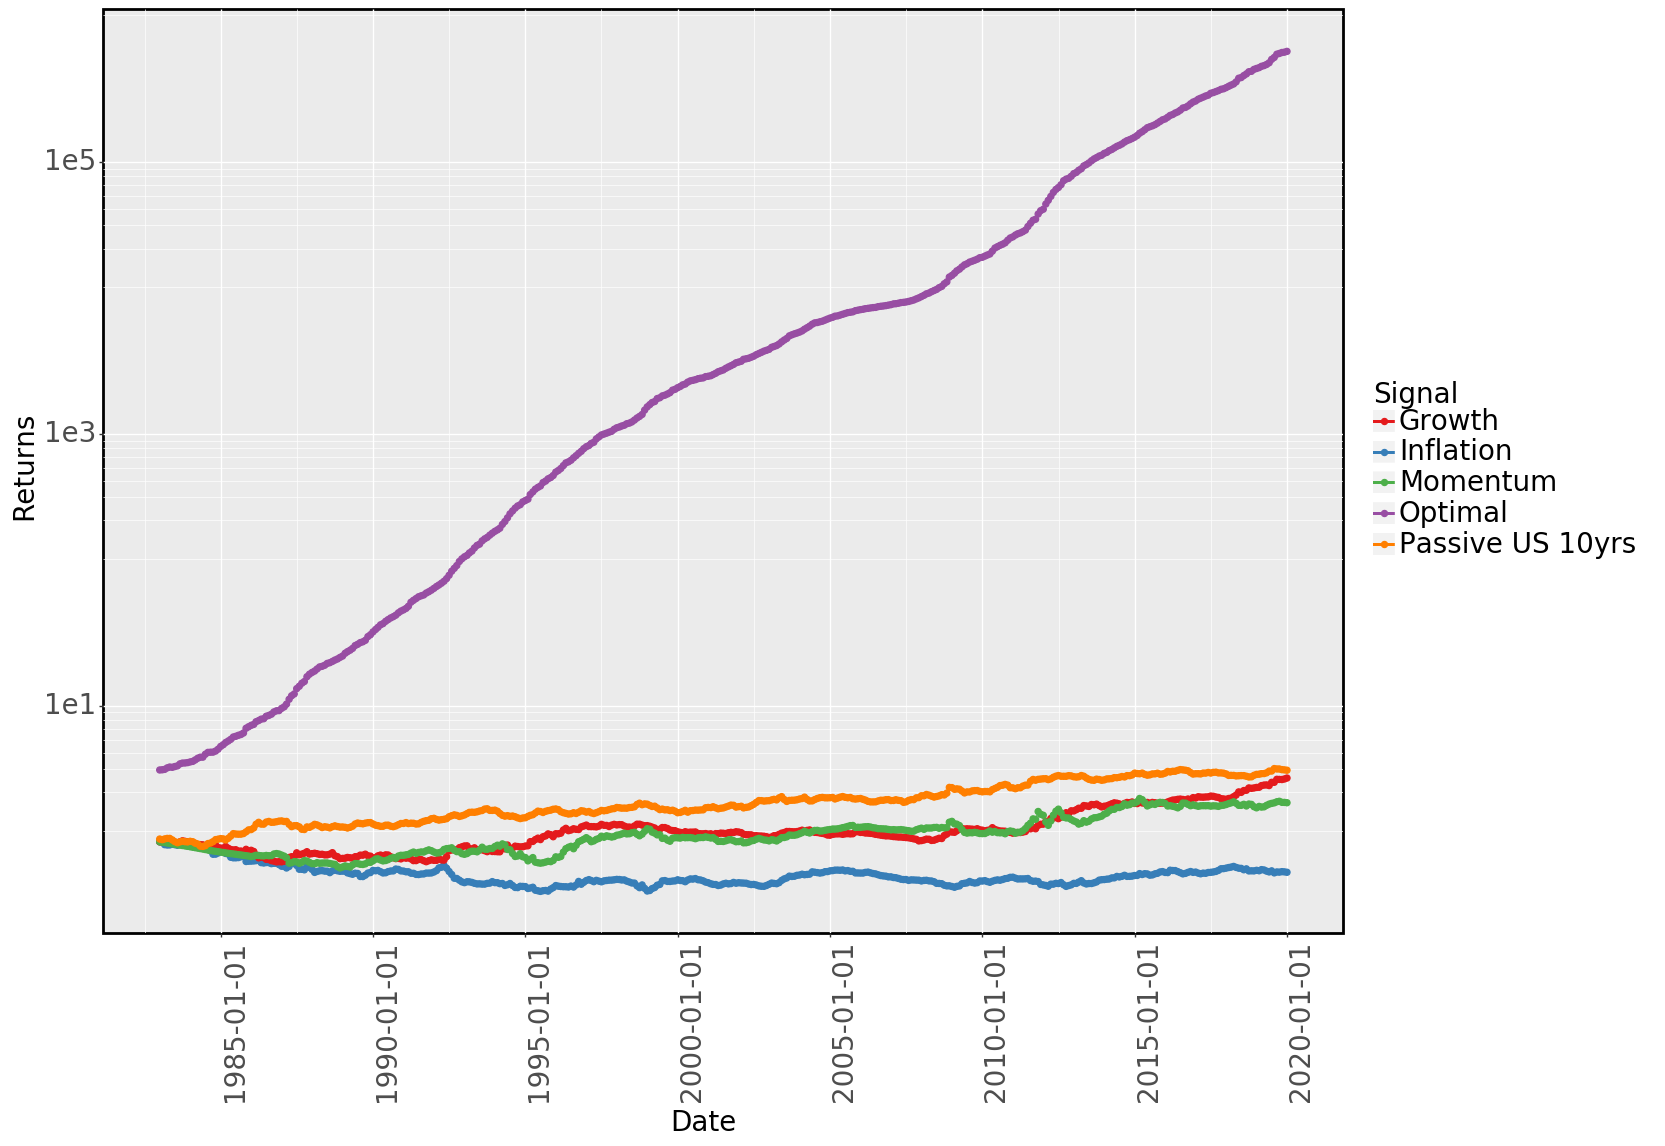

<ggplot: (8787175015246)>

In [339]:

df = {
    'Inflation': inflation_returns,
    'Growth': growth_returns,
    'Momentum': momentum_returns,

    'Optimal': optimal_returns,
    'Passive US 10yrs': passive_10yrs,
}
# for i in range(5):
#     df[f'random {i}'] = calc_signal_returns(bond_returns, get_random_signal(bond_returns))
df = pd.DataFrame(df)
df['date'] = df.index.to_series().map(lambda x: x.to_timestamp())
df = df.melt(id_vars='date')
df['color'] = df['variable'].map(lambda x: x.split()[0] if 'random' in x else x)
(
    ggplot(df, aes(x='date', y='value', color='color')) +
        geom_line(aes(group='variable')) +
        geom_point(aes(group='variable'), size=2) +
        scale_color_brewer(type='qualitative', palette=6) +
        ylab('Returns') +
        xlab('Date') +
        scale_x_date() +
        scale_y_log10() +
        labs(color='Signal') +
        theme(
            text=element_text(size=20),
            figure_size=(16, 12),
            legend_position='right',
            axis_text_x=element_text(size=20, angle=90, hjust=0),
            panel_border=element_rect(colour="black", size=2),
        )
)

In [402]:
# Combination Signals

combo1_sig = signalize(1 * inflation_sig + 1 * growth_sig + 2 * momentum_sig)
combo1_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, combo1_sig)
print('Combo 1 RAR', combo1_returns.iloc[-1])
print(' - Annualized Return', annualized_return(combo1_returns))
print(' - Sharpe Ration Combo 1:', sharpe_ratio(bond_returns, cash_rate, combo1_sig))
print(' - US 10yr Correlation w/ Combo 1:', pearsonr(passive_10yrs.pct_change().iloc[1:], combo1_returns.pct_change().iloc[1:])[0])

noinf_sig = signalize(0 * inflation_sig + 1 * growth_sig + 2 * momentum_sig)
noinf_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, noinf_sig)
print('No Inflation CER', noinf_returns.iloc[-1])
print(' - Annualized Return', annualized_return(noinf_returns))
print(' - Sharpe Ration No Inflation:', sharpe_ratio(bond_returns, cash_rate, noinf_sig))
print(' - US 10yr Correlation w/ No Inflation:', pearsonr(passive_10yrs.pct_change().iloc[1:], noinf_returns.pct_change().iloc[1:])[0])

nogro_sig = signalize(1 * inflation_sig + 0 * growth_sig + 2 * momentum_sig)
nogro_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, nogro_sig)
print('No Growth CER', nogro_returns.iloc[-1])
print(' - Sharpe Ration No Growth:', sharpe_ratio(bond_returns, cash_rate, nogro_sig))
print(' - US 10yr Correlation w/ No Growth:', pearsonr(passive_10yrs.pct_change().iloc[1:], nogro_returns.pct_change().iloc[1:])[0])


"""
combo2_sig = signalize(1 * inflation_sig + 0 * growth_sig + 1 * momentum_sig)
pick_growth = growth_sig.apply(extremity, axis=1) > 1.4 * combo2_sig.apply(extremity, axis=1)
combo2_sig[pick_growth] = growth_sig[pick_growth]
combo2_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, combo2_sig)
print('Combo 2 RAR', combo2_returns.iloc[-1])
print(' - Growth Picks (%)', 100 * pick_growth.sum() / pick_growth.shape[0])

combo3_sig = signalize(1 * inflation_sig + 1 * growth_sig + 2 * momentum_sig)
signal_weights = combo3_sig.apply(extremity, axis=1)
signal_weights **= 0.5
combo3_sig = (combo3_sig.T * signal_weights).T
combo3_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, combo3_sig, signal_weights=signal_weights)
print('Combo 3 RAR', combo3_returns.iloc[-1])

combo4_sig = signalize(1 * inflation_sig + 1 * growth_sig + 2 * momentum_sig)
signal_weights = signalize(5 * inflation_sig + -1 * growth_sig).apply(extremity, axis=1)
combo4_sig = (combo4_sig.T * signal_weights).T
combo4_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, combo4_sig, signal_weights=signal_weights)
print('Combo 4 RAR', combo4_returns.iloc[-1])

combo5_sig = signalize(1 * inflation_sig + 1 * growth_sig + 2 * momentum_sig)
signal_weights = 1 - momentum_sig.apply(extremity, axis=1)
combo5_sig = (combo5_sig.T * signal_weights).T
combo5_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, combo5_sig, signal_weights=signal_weights)
print('Combo 5 RAR', combo5_returns.iloc[-1])
"""

combo6_sig = signalize(1 * inflation_sig + 1 * growth_sig + 2 * momentum_sig)
signal_weights = combo6_sig.apply(extremity, axis=1)
signal_weights = signal_weights.rolling(3).mean().apply(lambda x: 1 if x > 0.8 else 0)
combo6_sig = (combo6_sig.T * signal_weights).T
combo6_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, combo6_sig, signal_weights=signal_weights)
combo6_vol_returns = calc_signal_risk_adj_vol_adj_returns(bond_returns, cash_rate, combo6_sig, signal_weights=signal_weights)
print('Combo 6 CER', combo6_returns.iloc[-1])
print('Combo 6 VOL CER', combo6_vol_returns.iloc[-1])
print(' - High Confidence %', 100 * signal_weights.mean())
print(' - Annualized Return', annualized_return(combo6_returns))
print(' - Sharpe Ration Combo 6:', sharpe_ratio(bond_returns, cash_rate, combo6_sig, signal_weights=signal_weights))
print(' - US 10yr Correlation w/ Combo 6:', pearsonr(passive_10yrs.pct_change().iloc[1:], combo6_returns.pct_change().iloc[1:])[0])

combo7_sig = (combo6_sig / combo6_sig.mean())
combo7_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, combo7_sig)
print('Combo 7 RAR', combo7_returns.iloc[-1])
print(' - Sharpe Ration Combo 7:', sharpe_ratio(bond_returns, cash_rate, combo7_sig))
print(' - US 10yr Correlation w/ Combo 7:', pearsonr(passive_10yrs.pct_change().iloc[1:], combo7_returns.pct_change().iloc[1:])[0])


Combo 1 RAR 4.965335611733414
 - Annualized Return 1.0444471109446767
 - Sharpe Ration Combo 1: 0.15586220862943775
 - US 10yr Correlation w/ Combo 1: 0.12223934879967666
No Inflation CER 4.524671896731451
 - Annualized Return 1.0418269341218807
 - Sharpe Ration No Inflation: 0.144259386002759
 - US 10yr Correlation w/ No Inflation: 0.1802396866942105
No Growth CER 2.0965835368130668
 - Sharpe Ration No Growth: 0.0758784558595487
 - US 10yr Correlation w/ No Growth: 0.12438314694467753
Combo 6 CER 5.4941536583473525
Combo 6 VOL CER 1.3828589284215747
 - High Confidence % 94.15730337078652
 - Annualized Return 1.0471229757538476
 - Sharpe Ration Combo 6: 0.16800648968461163
 - US 10yr Correlation w/ Combo 6: 0.11824081996812977
Combo 7 RAR 1.3413302275724233e-05
 - Sharpe Ration Combo 7: 0.15129383340305325
 - US 10yr Correlation w/ Combo 7: 0.08789772707776822


In [373]:
(combo6_sig.mean(axis=0)).rank()

country
JPN     1.0
CAN     5.0
ESP     9.0
DEU     2.0
ITA     7.0
GBR     8.0
NOR     4.0
AUS    10.0
USA     3.0
SWE     6.0
dtype: float64

In [397]:
def foo(country):
    passive_10yrs = get_passive_return(bond_returns, cash_rate, country=country)
    passive_10yrs = passive_10yrs.loc[START_DATE: END_DATE]#.dropna()
#     c6 = combo6_returns.pct_change().iloc[1:].copy()
#     c6 = c6.loc[passive_10yrs.index]
#     cdel = c6.replace([np.inf, -np.inf], np.nan).dropna()
#     pdel = passive_10yrs.pct_change().iloc[1:].replace([np.inf, -np.inf], np.nan).dropna()
#     pdel = pdel.loc[cdel.index].dropna()
#     cdel = cdel.loc[pdel.index]
#     print(country, 100 *pearsonr(pdel, cdel)[0])
    return passive_10yrs

df = {}
for c in bond_returns.columns:
    df[f'Passive {c} 10yrs'] = foo(c)
    
df = pd.DataFrame.from_dict(df, orient='columns')
rel_mean = (df.T / df.mean(axis=1)).T

100 * rel_mean.iloc[-1]

pearsonr(df.mean(axis=1).fillna(1).pct_change().iloc[1:], combo6_returns.pct_change().iloc[1:])[0]

0.1778773523683182

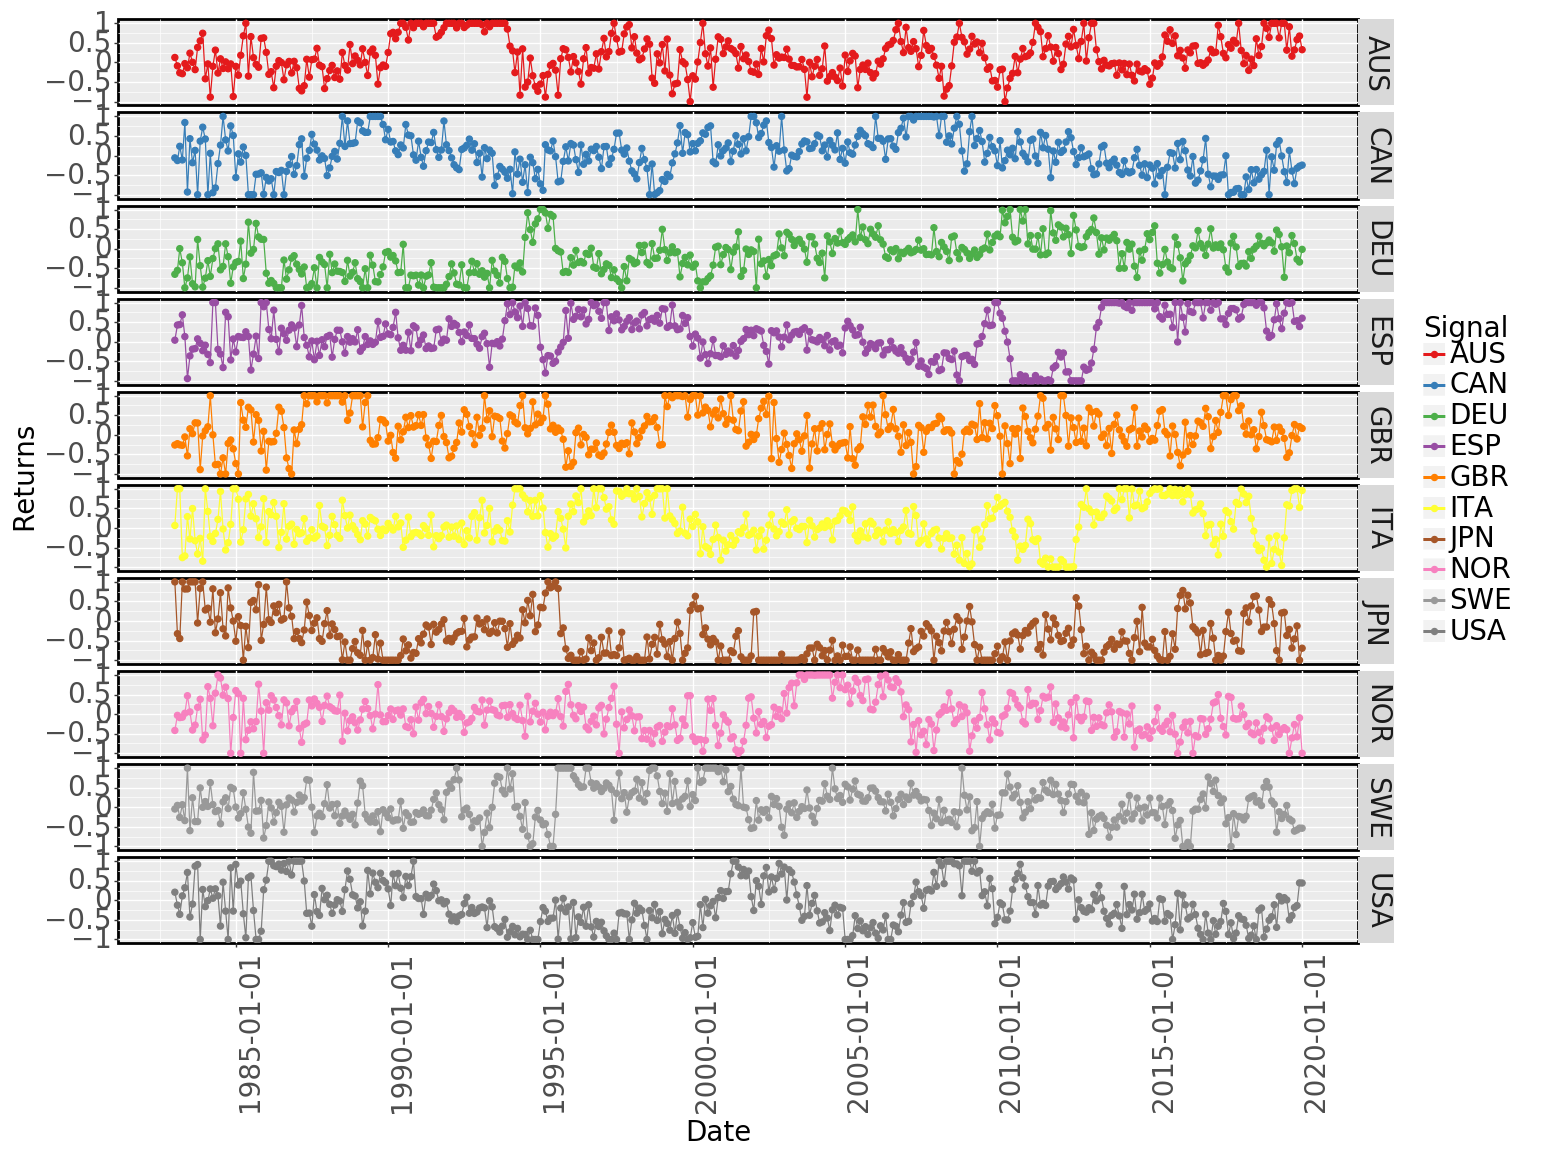

<ggplot: (-9223363249679242766)>

In [398]:
foo = combo1_sig.copy()
foo['date'] = foo.index.to_timestamp()
foo = foo.melt(id_vars='date')

(
    ggplot(foo, aes(x='date', y='value', color='country')) +
        geom_line() +
        geom_point(size=2) +
        scale_color_brewer(type='qualitative', palette=6) +
        facet_grid('country~.') +
        ylab('Returns') +
        xlab('Date') +
        scale_x_date() +

        labs(color='Signal') +
        theme(
            text=element_text(size=20),
            figure_size=(16, 12),
            legend_position='right',
            axis_text_x=element_text(size=20, angle=90, hjust=0),
            panel_border=element_rect(colour="black", size=2),
        )
)



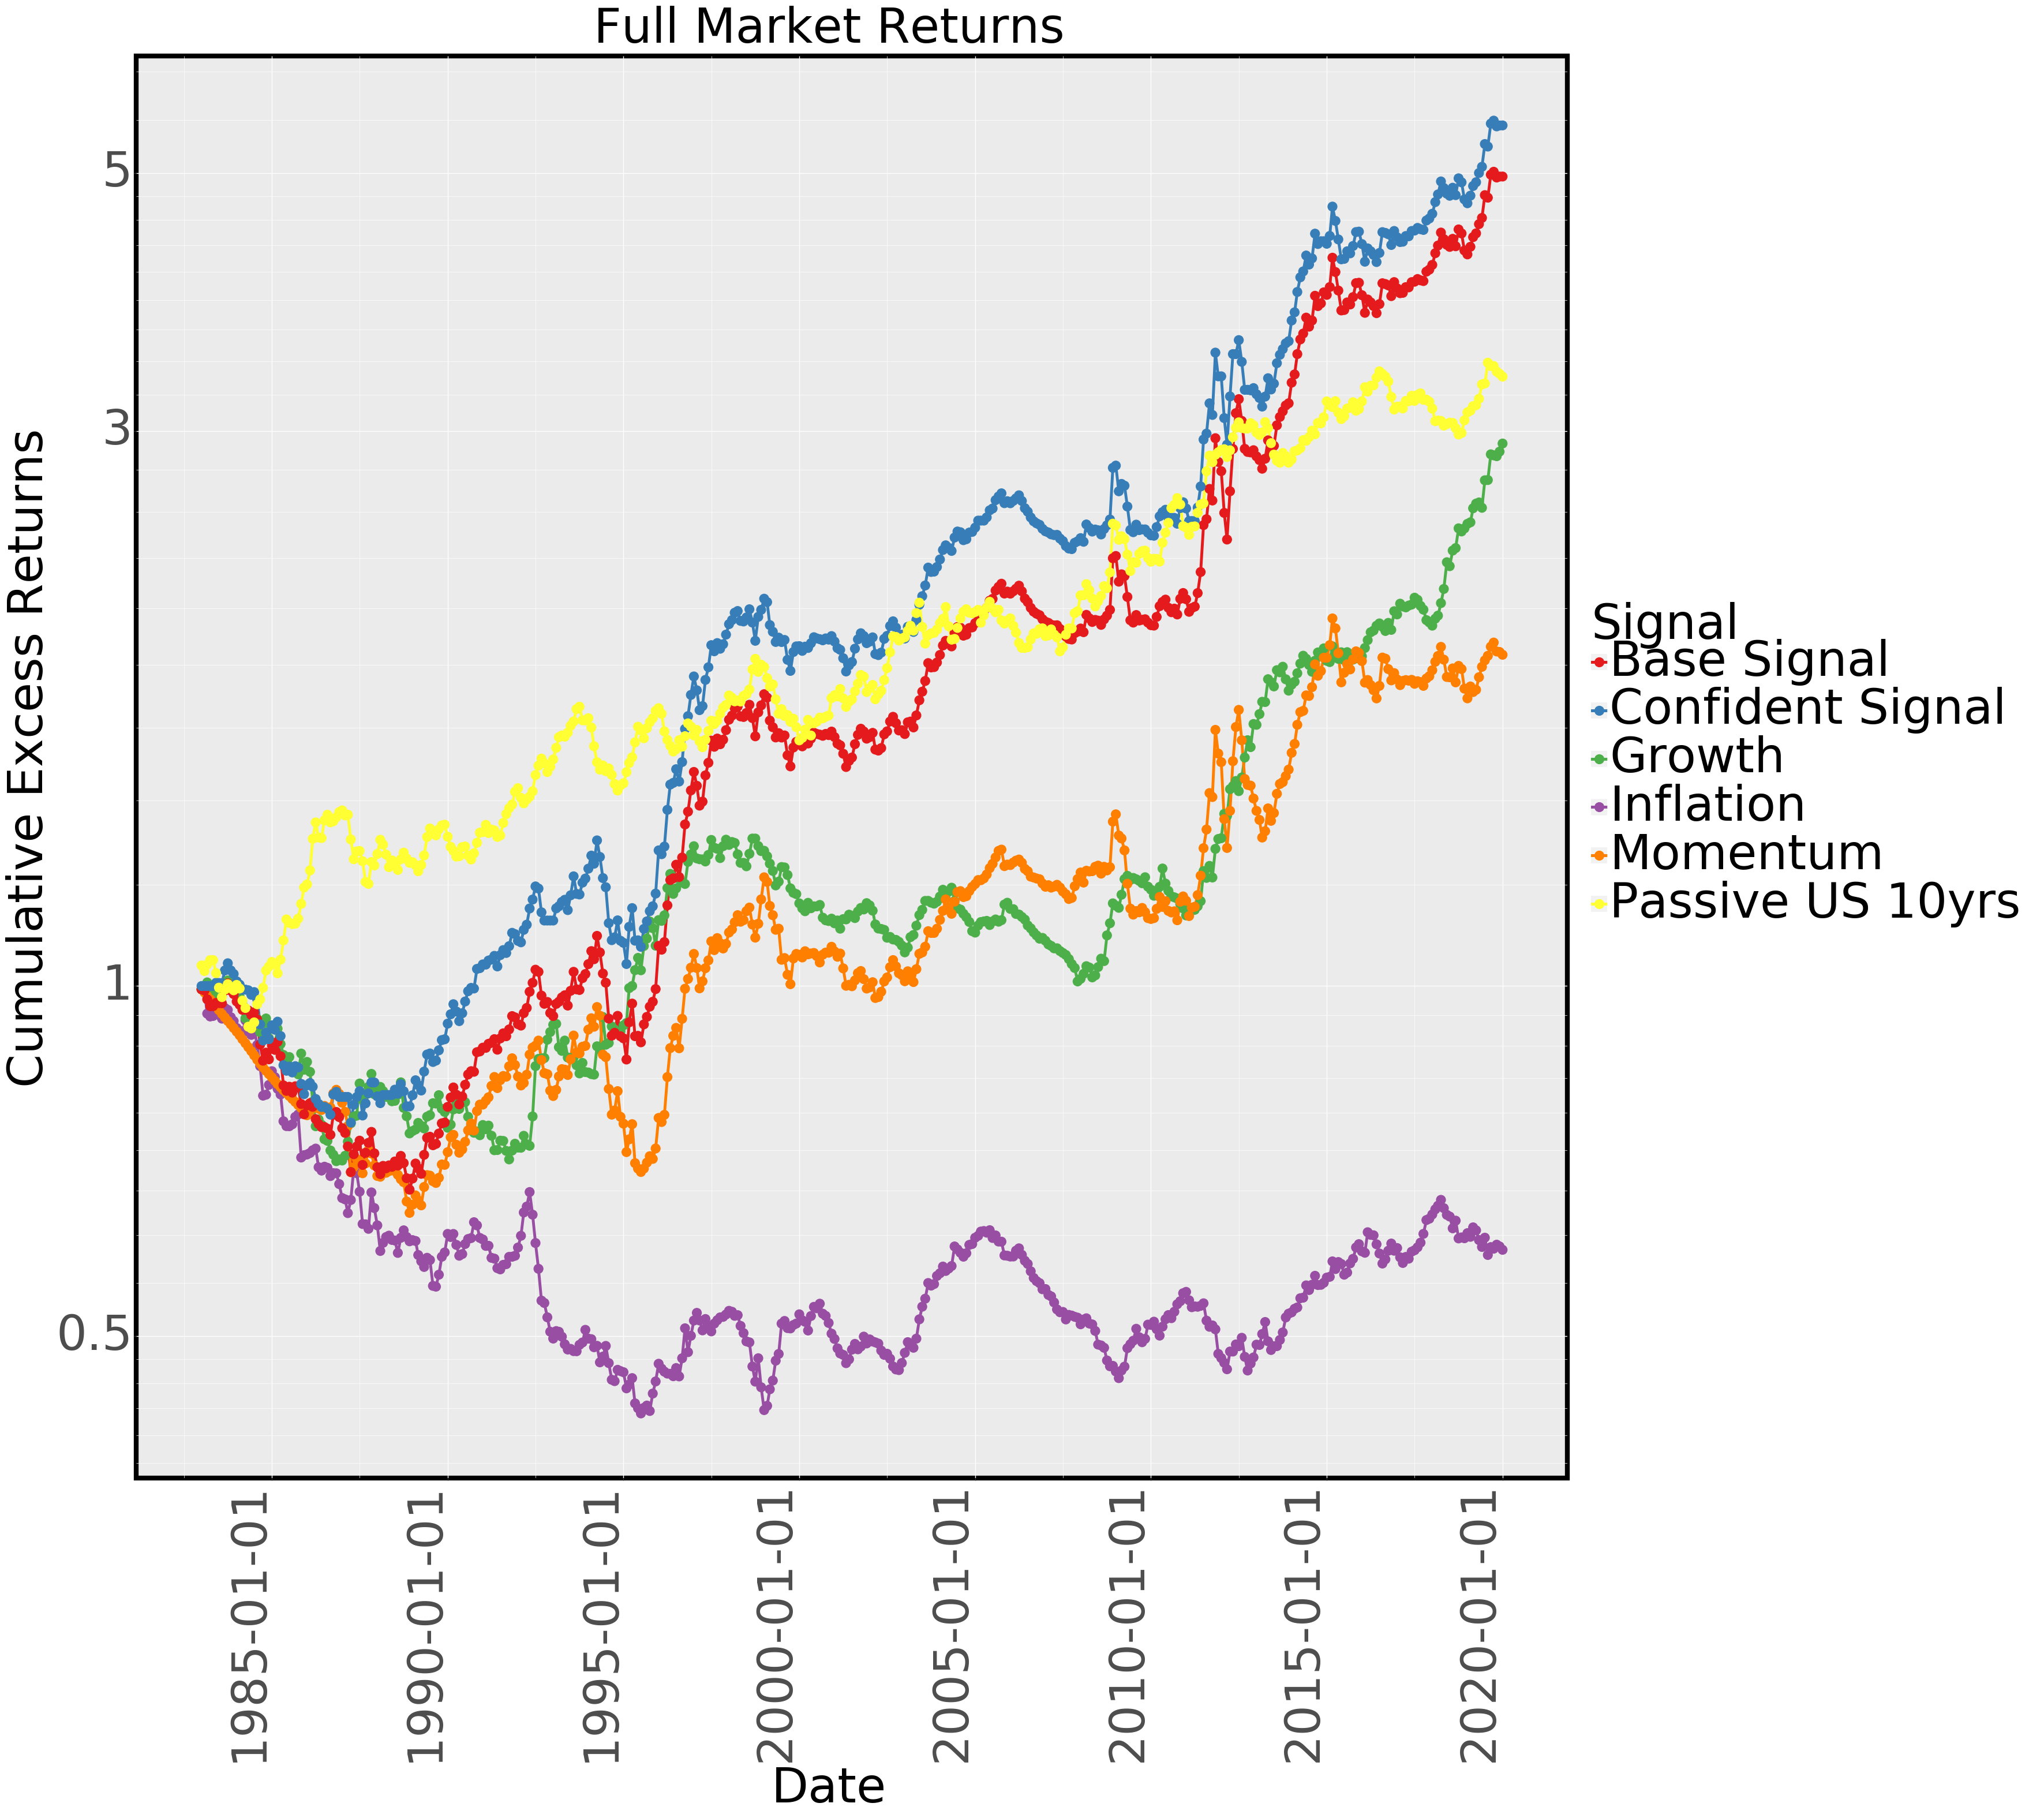

<ggplot: (8787209993743)>

In [351]:
df = {
    'Inflation': inflation_returns,
    'Growth': growth_returns,
    'Momentum': momentum_returns,
    
    'Base Signal': combo1_returns,
    #'Combo 2': combo2_returns,
    #'Combo 7': combo7_returns,
    'Confident Signal': combo6_returns,

    #'Optimal': optimal_returns,
    'Passive US 10yrs': passive_10yrs,
}
# for i in range(5):
#     df[f'random {i}'] = calc_signal_returns(bond_returns, get_random_signal(bond_returns))
df = pd.DataFrame(df)
df['date'] = df.index.to_series().map(lambda x: x.to_timestamp())
df = df.melt(id_vars='date')
df['color'] = df['variable'].map(lambda x: x.split()[0] if 'random' in x else x)
(
    ggplot(df, aes(x='date', y='value', color='color')) +
        geom_line(aes(group='variable'), size=2) +
        geom_point(aes(group='variable'), size=6) +
        scale_color_brewer(type='qualitative', palette=6) +
        ylab('Cumulative Excess Returns') +
        xlab('Date') +
        scale_x_date() +
        scale_y_log10() +
        labs(color='Signal') +
        ggtitle('Full Market Returns') +
        theme(
            text=element_text(size=60),
            figure_size=(32, 32),
            legend_position='right',
            axis_text_x=element_text(size=60, angle=90, hjust=1),
            panel_border=element_rect(colour="black", size=6),
        )
)

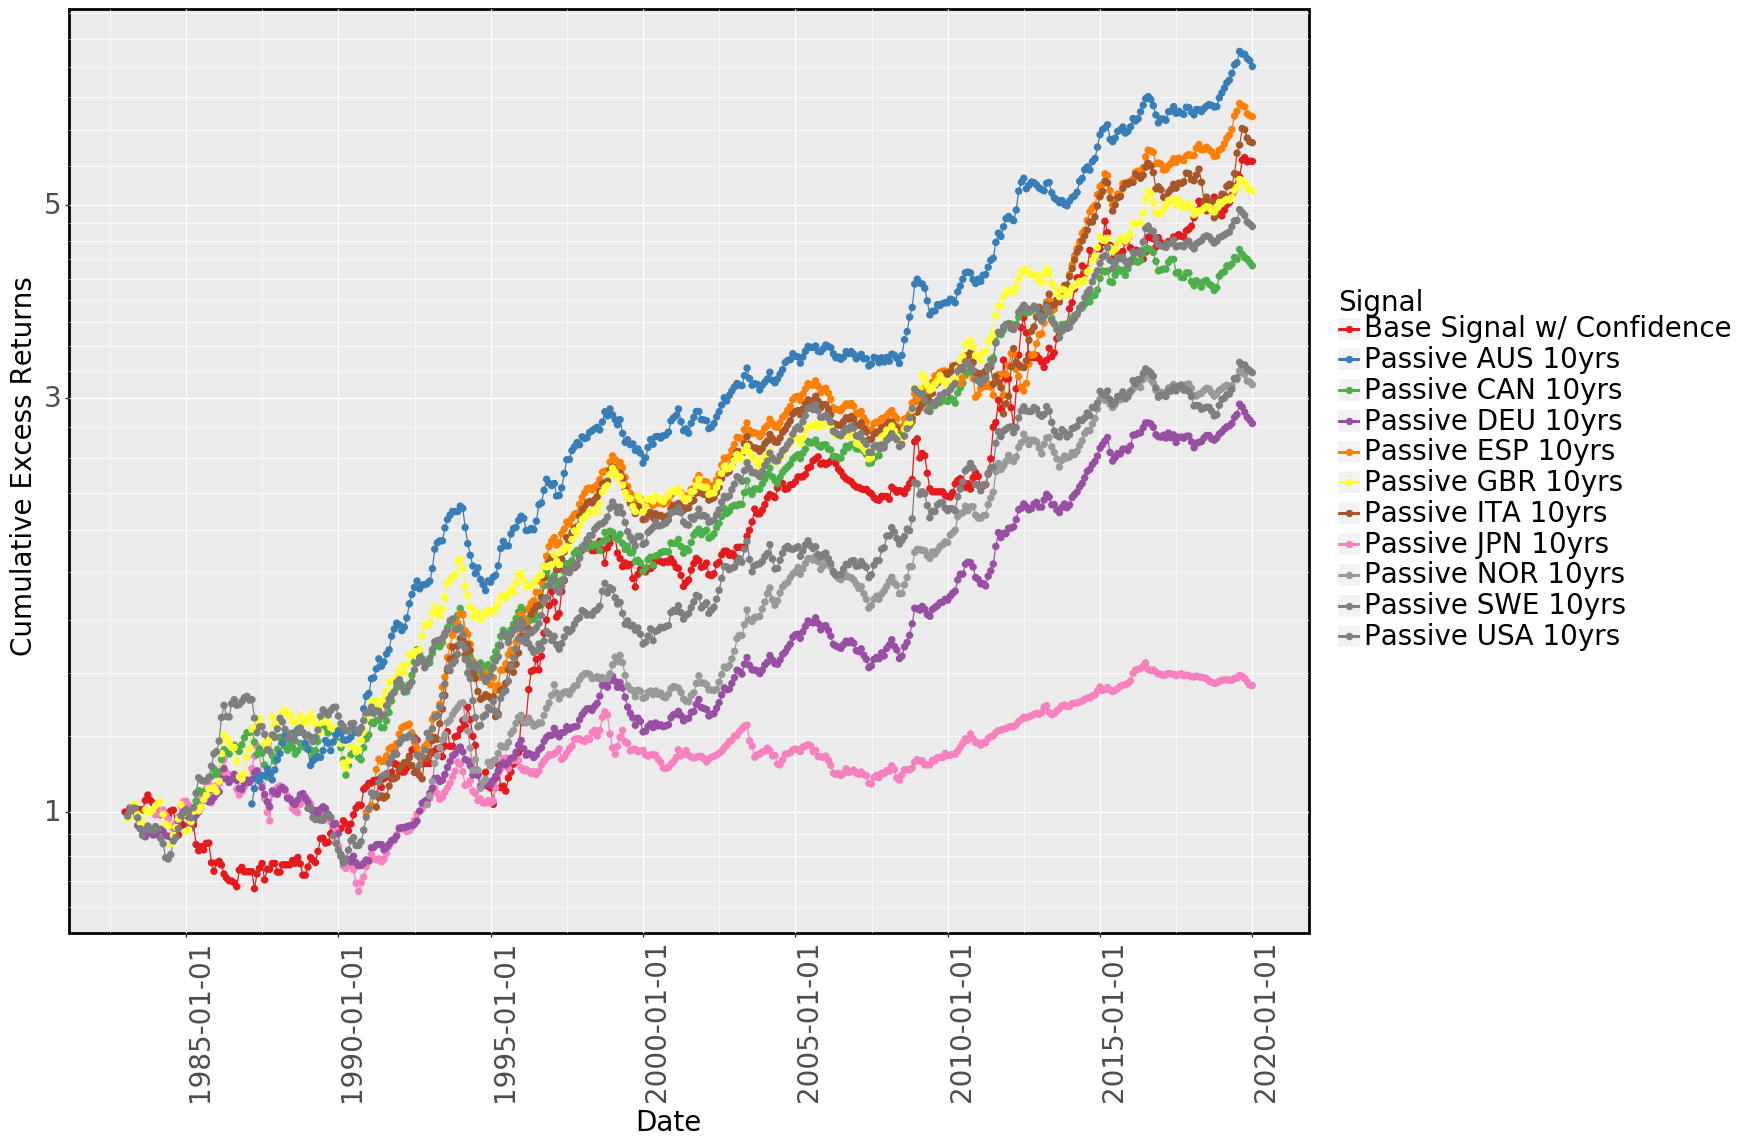

<ggplot: (-9223363249644784573)>

In [286]:
def foo(country):
    passive_10yrs = get_passive_return(bond_returns, cash_rate, country=country)
    passive_10yrs = passive_10yrs.loc[START_DATE: END_DATE]
    return passive_10yrs

df = {
    'Base Signal w/ Confidence': combo6_returns,
}
for c in bond_returns.columns:
    df[f'Passive {c} 10yrs'] = foo(c)
# for i in range(5):
#     df[f'random {i}'] = calc_signal_returns(bond_returns, get_random_signal(bond_returns))
df = pd.DataFrame(df)
df['date'] = df.index.to_series().map(lambda x: x.to_timestamp())
df = df.melt(id_vars='date')
df['color'] = df['variable'].map(lambda x: x.split()[0] if 'random' in x else x)
(
    ggplot(df, aes(x='date', y='value', color='color')) +
        geom_line(aes(group='variable')) +
        geom_point(aes(group='variable'), size=2) +
        scale_color_brewer(type='qualitative', palette=6) +
        ylab('Cumulative Excess Returns') +
        xlab('Date') +
        scale_x_date() +
        scale_y_log10() +
        labs(color='Signal') +
        theme(
            text=element_text(size=20),
            figure_size=(16, 12),
            legend_position='right',
            axis_text_x=element_text(size=20, angle=90, hjust=0),
            panel_border=element_rect(colour="black", size=2),
        )
)

In [323]:
b = bond_returns.copy()
b = b.applymap(lambda x: 0)
b['JPN'] = 1
b = b.loc['1990-01-01':'1995-01-01']
br = bond_returns.copy().loc['1991-01-01':'1994-01-01']
print(sharpe_ratio(br, cash_rate, b))
calc_signal_risk_adj_returns(br, cash_rate, b)


0.21915444319495012


date
1990-01    0.993566
1990-02    0.987135
1990-03    0.980745
1990-04    0.974397
1990-05    0.968120
             ...   
1994-09    1.163519
1994-10    1.158631
1994-11    1.153229
1994-12    1.147889
1995-01    1.142302
Freq: M, Length: 61, dtype: float64

In [300]:
get_passive_return(bond_returns, cash_rate)

date
1983-01         NaN
1983-02    0.989055
1983-03    1.001803
1983-04    1.010597
1983-05    1.010595
             ...   
2019-09    3.276206
2019-10    3.275791
2019-11    3.240071
2019-12    3.226223
2020-01    3.207916
Freq: M, Name: USA, Length: 445, dtype: float64

In [325]:
def get_passive_vol_adj_return(bond_returns, cash_rate, country='USA'):
    risk_free_returns = bond_returns[country].pct_change() + 1
    risk_free_returns -= cash_rate
    risk_free_returns = (risk_free_returns - 1) / (1 / risk_free_returns.std())
    risk_free_returns += 1
    risk_free_returns = risk_free_returns.cumprod()
    return risk_free_returns
    risk_free_returns = risk_free_returns.cumprod()
    return risk_free_returns
    risk_free_returns /= risk_free_returns.std()
    risk_free_returns += 1
    risk_free_returns = risk_free_returns.cumprod()
    return risk_free_returns

get_passive_vol_adj_return(bond_returns, cash_rate)

date
1983-01         NaN
1983-02    0.999802
1983-03    1.000035
1983-04    1.000194
1983-05    1.000194
             ...   
2019-09    1.022858
2019-10    1.022856
2019-11    1.022656
2019-12    1.022577
2020-01    1.022473
Freq: M, Name: USA, Length: 445, dtype: float64

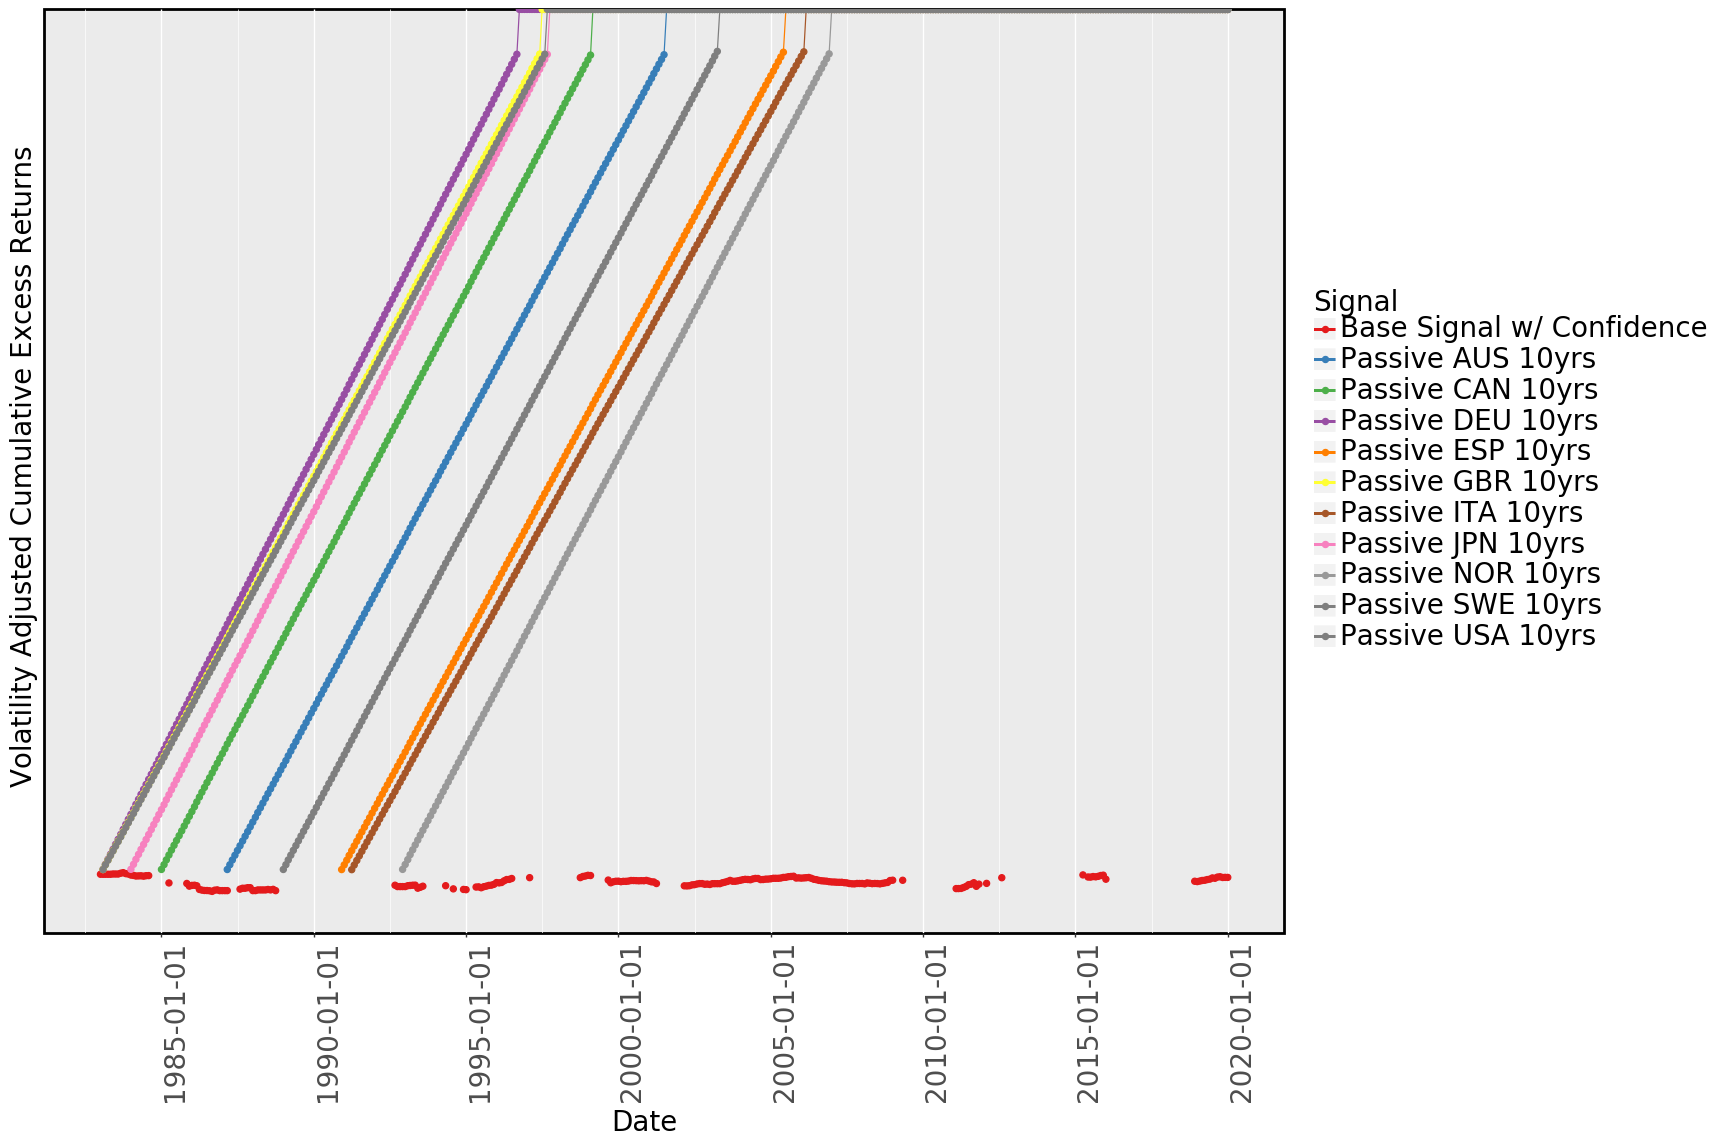

<ggplot: (-9223363249681906565)>

In [296]:
def foo(country):
    passive_10yrs = get_passive_vol_adj_return(bond_returns, cash_rate, country=country)
    passive_10yrs = passive_10yrs.loc[START_DATE: END_DATE]
    return passive_10yrs

df = {
    'Base Signal w/ Confidence': combo6_vol_returns,
}
for c in bond_returns.columns:
    df[f'Passive {c} 10yrs'] = foo(c)
# for i in range(5):
#     df[f'random {i}'] = calc_signal_returns(bond_returns, get_random_signal(bond_returns))
df = pd.DataFrame(df)
df['date'] = df.index.to_series().map(lambda x: x.to_timestamp())
df = df.melt(id_vars='date')
df['color'] = df['variable'].map(lambda x: x.split()[0] if 'random' in x else x)
(
    ggplot(df, aes(x='date', y='value', color='color')) +
        geom_line(aes(group='variable')) +
        geom_point(aes(group='variable'), size=2) +
        scale_color_brewer(type='qualitative', palette=6) +
        ylab('Volatility Adjusted Cumulative Excess Returns') +
        xlab('Date') +
        scale_x_date() +
        scale_y_log10() +
        labs(color='Signal') +
        theme(
            text=element_text(size=20),
            figure_size=(16, 12),
            legend_position='right',
            axis_text_x=element_text(size=20, angle=90, hjust=0),
            panel_border=element_rect(colour="black", size=2),
        )
)

In [287]:
bond_returns

country,JPN,CAN,ESP,DEU,ITA,GBR,NOR,AUS,USA,SWE
date,,,,,,,,,,
1983-01,NaN,NaN,NaN,63.300000,NaN,51.715619,NaN,NaN,53.456333,NaN
1983-02,NaN,NaN,NaN,63.207050,NaN,51.131250,NaN,NaN,53.206500,NaN
1983-03,NaN,NaN,NaN,64.863304,NaN,51.770696,NaN,NaN,54.264478,NaN
1983-04,NaN,NaN,NaN,64.871286,NaN,53.442238,NaN,NaN,55.096000,NaN
1983-05,NaN,NaN,NaN,64.508000,NaN,54.279909,NaN,NaN,55.474318,NaN
...,...,...,...,...,...,...,...,...,...,...
2019-09,333.194095,896.791524,1358.100190,684.272714,1252.452762,1019.190714,610.987476,1523.207476,646.267143,1187.939476
2019-10,331.660783,890.252522,1355.582565,675.759000,1250.003652,1015.373565,608.858696,1524.128870,646.992913,1179.463696
2019-11,329.297476,887.453286,1332.620571,667.510714,1223.812095,1004.591571,599.213857,1508.715000,640.763905,1160.987952


In [288]:
def one_trial(dlib, mask, start_date, end_date):
    bond_returns, cash_rate, optimal_returns, passive_10yrs = get_setup(dlib, mask, start_date, end_date)
    momentum_sig, momentum_returns = get_momentum(bond_returns, start_date, end_date)
    growth_sig, growth_returns = get_growth(dlib, mask, start_date, end_date)
    inflation_sig, inflation_returns = get_inflation(dlib, mask, start_date, end_date)
    
    combo1_sig = signalize(1 * inflation_sig + 1 * growth_sig + 2 * momentum_sig)
    combo1_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, combo1_sig)
    print('Combo 1 RAR', combo1_returns.iloc[-1])
    combo1_sharpe = sharpe_ratio(bond_returns, cash_rate, combo1_sig)
    print(' - Sharpe Ration Combo 1:', combo1_sharpe)
    combo1_pearsonr = pearsonr(passive_10yrs.pct_change().iloc[1:], combo1_returns.pct_change().iloc[1:])[0]
    print(' - US 10yr Correlation w/ Combo 1:', combo1_pearsonr)
    
    combo6_sig = signalize(1 * inflation_sig + 1 * growth_sig + 2 * momentum_sig)
    signal_weights = combo6_sig.apply(extremity, axis=1)
    signal_weights = signal_weights.rolling(3).mean().apply(lambda x: 1 if x > 0.8 else 0)
    combo6_sig = (combo6_sig.T * signal_weights).T
    combo6_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, combo6_sig, signal_weights=signal_weights)
    print('Combo 6 RAR', combo6_returns.iloc[-1])
    combo6_sharpe = sharpe_ratio(bond_returns, cash_rate, combo6_sig, signal_weights=signal_weights)
    print(' - Sharpe Ration Combo 6:', combo6_sharpe)
    combo6_pearsonr = pearsonr(passive_10yrs.pct_change().iloc[1:], combo6_returns.pct_change().iloc[1:])[0]
    print(' - US 10yr Correlation w/ Combo 6:', combo6_pearsonr)
    
    return {
        'combo_1': (combo1_returns.iloc[-1], combo1_sharpe, combo1_pearsonr),
        'combo_6': (combo6_returns.iloc[-1], combo6_sharpe, combo6_pearsonr),
    }
    
one_trial(dlib, mask, START_DATE, END_DATE)

Net Momentum RAR 1.9266483464224644
Net GDP CER 0.29655167274603517
Net Equity CER 2.533471857950543
GDP Picks (%) 6.51685393258427
Net Growth CER 2.9269140150497788
Net M2 RAR 0.3036495961245047
Net CPI RAR 0.4245303976748969
Net FX RAR 0.40547000751921825
Net Inflation RAR 0.5313300771122954
Combo 1 RAR 5.104248602025248
 - Sharpe Ration Combo 1: 0.15829054340969387
 - US 10yr Correlation w/ Combo 1: 0.12448055403194315
Combo 6 RAR 5.621065255002278
 - Sharpe Ration Combo 6: 0.1693568698198046
 - US 10yr Correlation w/ Combo 6: 0.13175094441614707


{'combo_1': (5.104248602025248, 0.15829054340969387, 0.12448055403194315),
 'combo_6': (5.621065255002278, 0.1693568698198046, 0.13175094441614707)}

In [ ]:
COUNTRIES = ['JPN', 'CAN', 'ESP', 'DEU', 'ITA', 'GBR', 'NOR', 'AUS', 'USA', 'SWE']
TIMES = [
    1985,
    1990,
    1995,
    2000,
    2005,
    2010,
]


tbl = {}
for _ in range(10):
    countries = list(set(random.choices(COUNTRIES, k=8)) | set(['USA']))
    print(countries)
    for time in TIMES:
        print(f'{time}-01-01')
        def my_mask(tbl):
            tbl = tbl[countries]
            tbl = tbl.loc[f'{time - 3}-01-01':f'{time + 10}-01-01']
            return tbl
        
        out = one_trial(dlib, my_mask, f'{time}-01-01', f'{time + 10}-01-01')
        for k, v in out.items():
            tbl[(tuple(sorted(countries)), time, k)] = v

tbl = pd.DataFrame.from_dict(tbl, orient='index', columns=['return', 'sharpe', 'correlation'])

['GBR', 'ITA', 'USA', 'NOR', 'AUS']
1985-01-01
Net Momentum RAR 0.6521672984130223
Net GDP RAR 0.2828175458538455
Net Equity RAR 0.6089932029843879
GDP Picks (%) 6.6115702479338845
Net Growth RAR 0.6097374519037881
Net M2 RAR 0.3485351276047731
Net CPI RAR 0.2358677010888178
Net FX RAR 0.3970465030174515
Net Inflation RAR 0.43159443433342953
Combo 1 RAR 1.0487919444356628
 - Sharpe Ration Combo 1: 0.028684493376840203
 - US 10yr Correlation w/ Combo 1: -0.21518026581854852
Combo 6 RAR 1.2023488867265546
 - Sharpe Ration Combo 6: 0.08275236795434346
 - US 10yr Correlation w/ Combo 6: -0.18431199492762698
1990-01-01
Net Momentum RAR 0.8482175193288708
Net GDP RAR 0.3519263569109185
Net Equity RAR 0.5938396713357652
GDP Picks (%) 4.958677685950414
Net Growth RAR 0.577702797004836
Net M2 RAR 0.2490738223635535
Net CPI RAR 0.3518012930508746
Net FX RAR 0.3056335974318767
Net Inflation RAR 0.30075205763514234
Combo 1 RAR 1.3160077400568353
 - Sharpe Ration Combo 1: 0.13191318059116444
 - US 

In [ ]:
tbl

In [ ]:
t = tbl.copy()
t['start_year'] = tbl.index.map(lambda x: str(x[1]))
t['method'] = tbl.index.map(lambda x: str(x[2]))
(
    ggplot(t, aes(x='return', fill='start_year')) +
        geom_density() +
        facet_grid('start_year~method') +
        scale_fill_brewer(type='qualitative', palette=6) +
        xlab('Returns') +
        theme(
            text=element_text(size=20),
            figure_size=(12, 8),
            legend_position='right',
            axis_text_x=element_text(size=20, angle=90, hjust=0),
            panel_border=element_rect(colour="black", size=2),
        )
)

In [22]:
def get_cpi(dlib, mask, start_date, end_date):
    cpi = mask(dlib.pull('CoreCPI-SA'))
    W = 12
    cpi = cpi.rolling(W).apply(lambda x: (x[W - 2] - x[W - 1])/ x[:W - 1].max())
#     cpi = derivative(cpi, s=3)
#     cpi = center_scale_using_historical_rolling(cpi, window=6, gap=1)
    cpi_sig = signalize(cpi).fillna(0)
    cpi_sig = cpi_sig.loc[start_date:end_date]
    cpi_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, cpi_sig)
    print('Net CPI RAR', cpi_returns.iloc[-1])
    return cpi_sig, cpi_returns

cpi_sig, cpi_returns = get_cpi(dlib, mask, START_DATE, END_DATE)


Net CPI RAR 0.34282307718869176


In [19]:
# Inflation

def get_m2(dlib, mask, start_date, end_date):
    m2 = mask(dlib.pull('M2-inUSD'))
    m2_3m = m2.rolling(3).mean()
    m2_12m = m2.rolling(12).mean()
    m2 = m2_3m / m2_12m
    m2 = center_scale_using_historical_rolling(m2, window=6, gap=1)
    m2_sig = signalize(m2).fillna(0)
    m2_sig = m2_sig.loc[start_date:end_date]
    m2_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, m2_sig)
    print('Net M2 RAR', m2_returns.iloc[-1])
    return m2_sig, m2_returns

def get_cpi(dlib, mask, start_date, end_date):
    cpi = mask(dlib.pull('CoreCPI-SA'))
    cpi = cpi.rolling(12).apply(lambda x: (x[11] - x[10])/ x[:11].max())
    cpi = derivative(cpi, s=3)
    cpi = center_scale_using_historical_rolling(cpi, window=6, gap=1)
    cpi_sig = signalize(cpi).fillna(0)
    cpi_sig = cpi_sig.loc[start_date:end_date]
    cpi_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, cpi_sig)
    print('Net CPI RAR', cpi_returns.iloc[-1])
    return cpi_sig, cpi_returns

def get_fx(dlib, mask, start_date, end_date):
    fx = mask(dlib.pull('fxVsUSD'))
    fx['USA'] = 1 / fx.drop(columns='USA').mean(axis=1)
    W = 2
    fx = fx.rolling(W).apply(lambda x: x[W - 1] / x[:W - 1].mean())
    fx = derivative(fx, s=6)
    fx = fx.applymap(lambda x: 1 / x)
    fx_sig = signalize(fx.resample('M').mean()).fillna(0)
    fx_sig = fx_sig.loc[start_date:end_date]
    fx_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, fx_sig)
    print('Net FX RAR', fx_returns.iloc[-1])
    return fx_sig, fx_returns

def get_inflation(dlib, mask, start_date, end_date):
    m2_sig, m2_returns = get_m2(dlib, mask, start_date, end_date)
    cpi_sig, cpi_returns = get_cpi(dlib, mask, start_date, end_date)
    fx_sig, fx_returns = get_fx(dlib, mask, start_date, end_date)
    inflation_sig = signalize(2 * fx_sig + 1 * cpi_sig + 2 * m2_sig)
    inflation_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, inflation_sig)
    print('Net Inflation RAR', inflation_returns.iloc[-1])
    return inflation_sig, inflation_returns


inflation_sig, inflation_returns = get_inflation(dlib, mask, START_DATE, END_DATE)

Net M2 RAR 0.3036495961245047
Net CPI RAR 0.21356554273253203
Net FX RAR 0.40547000751921825
Net Inflation RAR 0.4717447745437812


Net M2 RAR 0.3036495961245047
Net CPI RAR 0.34282307718869176
Net FX RAR 0.40547000751921825
Net M2 RAR 0.3036495961245047
Net CPI RAR 0.34282307718869176
Net FX RAR 0.40547000751921825
Net Inflation RAR 0.5120532366158358


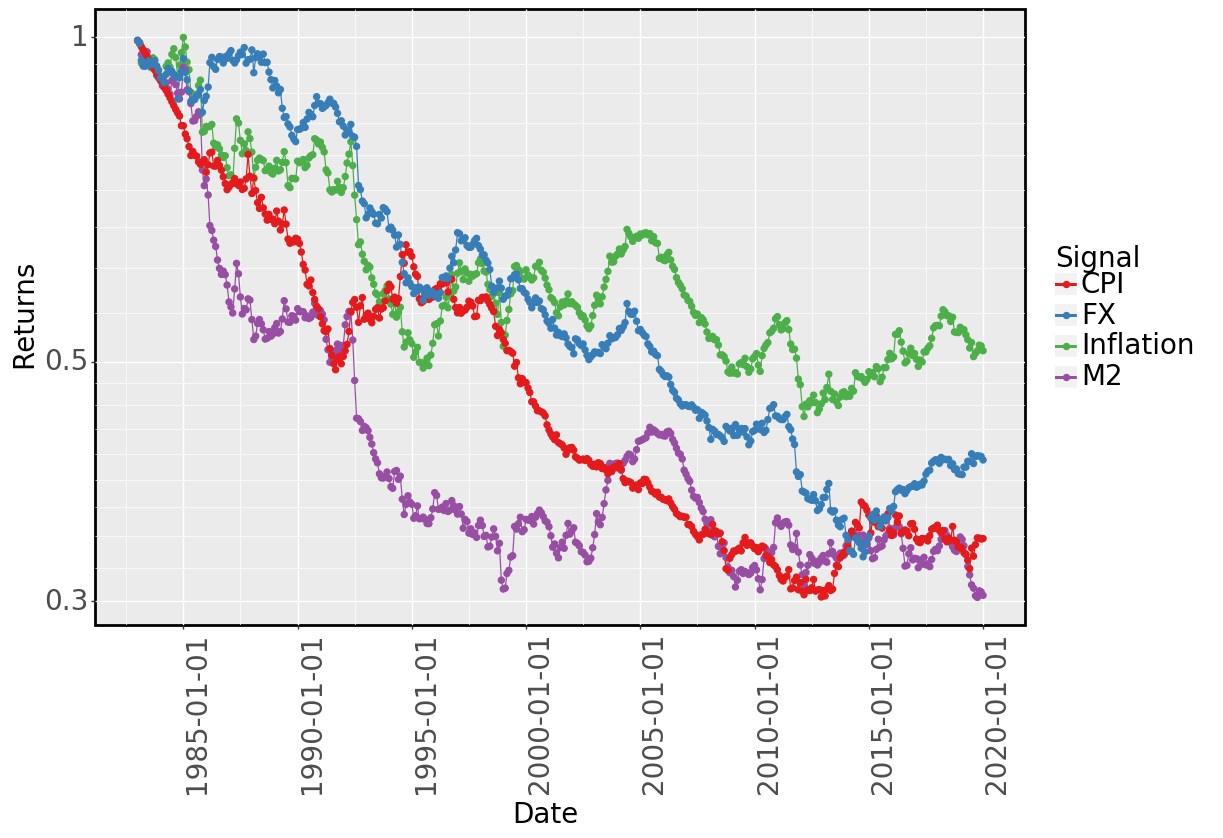

<ggplot: (-9223363249643867213)>

In [24]:
m2_sig, m2_returns = get_m2(dlib, mask, START_DATE, END_DATE)
cpi_sig, cpi_returns = get_cpi(dlib, mask, START_DATE, END_DATE)
fx_sig, fx_returns = get_fx(dlib, mask, START_DATE, END_DATE)
inflation_sig, inflation_returns = get_inflation(dlib, mask, START_DATE, END_DATE)
df = {
    'Inflation': inflation_returns,
    'M2': m2_returns,
    'CPI': cpi_returns,
    'FX': fx_returns,
}
df = pd.DataFrame(df)
df['date'] = df.index.to_series().map(lambda x: x.to_timestamp())
df = df.melt(id_vars='date')
(
    ggplot(df, aes(x='date', y='value', color='variable')) +
        geom_line(aes(group='variable')) +
        geom_point(aes(group='variable'), size=2) +
        scale_color_brewer(type='qualitative', palette=6) +
        ylab('Cumulative Excess Returns') +
        xlab('Date') +
        scale_x_date() +
        scale_y_log10() +
        labs(color='Signal') +
        theme(
            text=element_text(size=20),
            figure_size=(12, 8),
            legend_position='right',
            axis_text_x=element_text(size=20, angle=90, hjust=0),
            panel_border=element_rect(colour="black", size=2),
        )
)

Net GDP RAR 0.29655167274603517
Net Equity RAR 2.533471857950543
Net GDP RAR 0.29655167274603517
Net Equity RAR 2.533471857950543
GDP Picks (%) 6.51685393258427
Net Growth RAR 2.9269140150497788


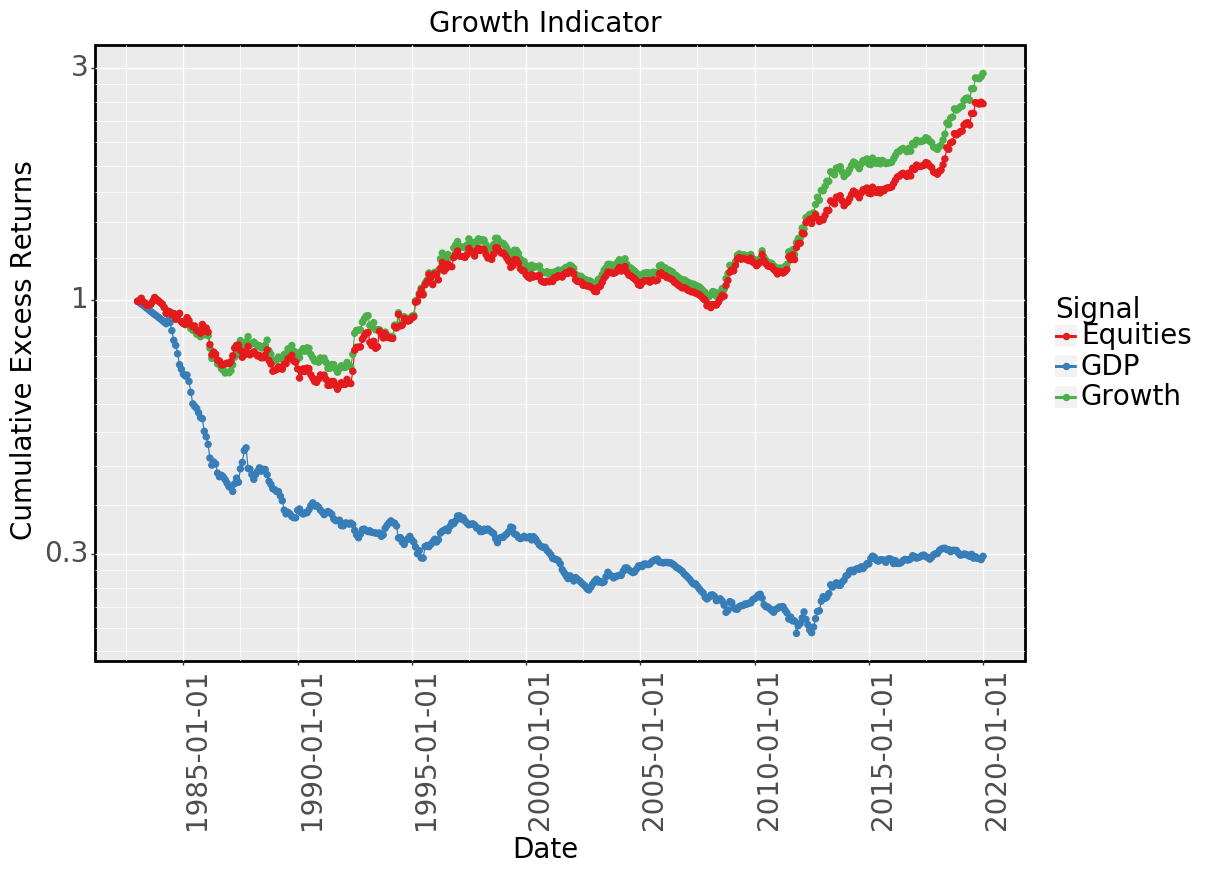

<ggplot: (8787209994532)>

In [42]:
gdp_sig, gdp_returns = get_gdp(dlib, mask, START_DATE, END_DATE)
eqs_sig, eqs_returns = get_eqs(dlib, mask, START_DATE, END_DATE)
growth_sig, growth_returns = get_growth(dlib, mask, START_DATE, END_DATE)
df = {
    'Growth': growth_returns,
    'GDP': gdp_returns,
    'Equities': eqs_returns,
}
df = pd.DataFrame(df)
df['date'] = df.index.to_series().map(lambda x: x.to_timestamp())
df = df.melt(id_vars='date')
(
    ggplot(df, aes(x='date', y='value', color='variable')) +
        geom_line(aes(group='variable')) +
        geom_point(aes(group='variable'), size=2) +
        scale_color_brewer(type='qualitative', palette=6) +
        ylab('Cumulative Excess Returns') +
        xlab('Date') +
        scale_x_date() +
        scale_y_log10() +
        ggtitle('Growth Indicator') +
        labs(color='Signal') +
        theme(
            text=element_text(size=20),
            figure_size=(12, 8),
            legend_position='right',
            axis_text_x=element_text(size=20, angle=90, hjust=0),
            panel_border=element_rect(colour="black", size=2),
        )
)

In [196]:
def calc_country_wise_signal_returns(bond_returns, cash_rate, signal, signal_weights=1):
    """Return a Series of returns (as fraction of initial investment) for a signal."""
    signal = signal.copy().fillna(0)
    bond_returns = bond_returns.pct_change()
    signal_returns = bond_returns * signal
    #signal_returns = signal_returns.sum(axis=1)
    #return signal_returns
    signal_returns += 1
    #return signal_returns
    signal_returns = signal_returns.cumprod()
    return signal_returns


brs = bond_returns[['JPN', 'USA']]
ones = pd.DataFrame(np.ones(brs.shape), columns=brs.columns, index=brs.index)
calc_country_wise_signal_returns(brs, cash_rate, ones)

country,JPN,USA
date,,
1983-01,NaN,NaN
1983-02,NaN,0.995326
1983-03,NaN,1.015118
1983-04,NaN,1.030673
1983-05,NaN,1.037750
...,...,...
2019-09,4.902869,12.089627
2019-10,4.880307,12.103204
2019-11,4.845532,11.986679


In [248]:
def calc_country_wise_signal_returns(bond_returns, cash_rate, signal, signal_weights=1):
    """Return a Series of returns (as fraction of initial investment) for a signal."""
    signal = signal.copy().fillna(0)
    bond_returns = bond_returns.pct_change().fillna(0)
    signal_returns = bond_returns * signal
    signal_returns = signal_returns.sum(axis=1)
    #return signal_returns
    signal_returns += 1
    #return signal_returns
    signal_returns = signal_returns.cumprod()
    return signal_returns


brs = bond_returns.loc['1995-01-01':][['JPN', 'USA']]
ones = pd.DataFrame(np.ones(brs.shape), columns=brs.columns, index=brs.index)
calc_country_wise_signal_returns(brs, cash_rate, ones)

date
1995-01    1.000000
1995-02    1.037068
1995-03    1.102538
1995-04    1.169505
1995-05    1.229670
             ...   
2019-09    9.596340
2019-10    9.562956
2019-11    9.402745
2019-12    9.302221
2020-01    9.264205
Freq: M, Length: 301, dtype: float64

In [267]:
1.157625 * 1.2 + 1.157625 * 0.9

2.4310124999999996

In [181]:
bond_returns.loc['1995-01-01':]

country,JPN,CAN,ESP,DEU,ITA,GBR,NOR,AUS,USA,SWE
date,,,,,,,,,,
1995-01,135.524500,169.292409,166.187545,142.865227,157.232727,184.152318,122.522545,213.488045,161.052455,180.757364
1995-02,136.847850,175.449950,170.338000,145.368200,158.596400,186.224900,124.733050,217.442750,165.449750,185.587900
1995-03,142.332043,179.556261,165.212957,147.704870,151.157696,188.269174,125.696478,219.583130,169.264174,181.652217
1995-04,148.674200,183.416350,168.434100,150.426000,153.054400,191.563100,128.447550,226.158900,172.002900,180.651350
1995-05,151.134826,188.831522,176.214739,153.459304,163.655826,196.114304,131.728652,237.932304,178.004826,189.859913
...,...,...,...,...,...,...,...,...,...,...
2019-09,333.194095,896.791524,1358.100190,684.272714,1252.452762,1019.190714,610.987476,1523.207476,646.267143,1187.939476
2019-10,331.660783,890.252522,1355.582565,675.759000,1250.003652,1015.373565,608.858696,1524.128870,646.992913,1179.463696
2019-11,329.297476,887.453286,1332.620571,667.510714,1223.812095,1004.591571,599.213857,1508.715000,640.763905,1160.987952


In [247]:
1.3225 * 1.6 + 1.71925

3.8352500000000003

In [205]:
def calc_signal_risk_adj_returns(bond_returns, cash_rate, signal, signal_weights=1):
    """Return a Series of returns (as fraction of initial investment) for a signal."""
    signal = signal.copy().fillna(0)
    bond_returns = bond_returns.pct_change()
    signal_returns = bond_returns * signal
    signal_returns = signal_returns.sum(axis=1) 
    signal_returns -= cash_rate
    signal_returns *= signal_weights
    signal_returns += 1
    signal_returns = signal_returns.cumprod()
    return signal_returns

country,JPN,USA
date,,
1983-01,NaN,53.456333
1983-02,NaN,53.206500
1983-03,NaN,54.264478
1983-04,NaN,55.096000
1983-05,NaN,55.474318
...,...,...
2019-09,333.194095,646.267143
2019-10,331.660783,646.992913
2019-11,329.297476,640.763905
